<a href="https://colab.research.google.com/github/Matvej911/Matvejs_edgeAi/blob/main/age_gender_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0


In [2]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [9]:
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt



import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


### This section mounts your Google Drive to Colab so you can access files stored there.
### You need to grant permission when prompted, and your Google Drive will be available at `/content/drive`.

Before running the following code, please ensure you have uploaded your dataset to Google Drive. Follow these steps:

Prepare Your Dataset:

Make sure your dataset is in a zip file format, named archive1.zip.
The zip file should contain your training and validation images organized into separate directories for each emotion.
Upload to Google Drive:

Upload the emotion.zip file to your Google Drive. You can place it in any folder, but for simplicity, you might want to place it in the root directory of your Drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp "/content/drive/MyDrive/archive/archive1.zip" /content/

In [7]:
import zipfile
import os

zip_path = '/content/archive1.zip'
extract_path = '/content/utkface_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

['UTKFace']


### Data Preparation for Age and Gender Prediction using UTKFace Dataset

The processed images are normalized, and the dataset is split into training and testing sets for both age and gender prediction tasks. The entire process is designed to facilitate further model training and evaluation in deep learning applications.

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

# Directory where the dataset images are located
BASE_DIR = '/content/utkface_dataset/UTKFace'

# Lists to store image paths and corresponding labels
image_paths = []
age_labels = []
gender_labels = []

# Loop through the dataset and extract the age and gender from the filenames
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')

    # Ensure the filename has at least two parts (age and gender)
    if len(temp) >= 2:
        try:
            age = int(temp[0])  # First part of the filename is the age
            gender = int(temp[1])  # Second part of the filename is the gender
            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
        except ValueError:
            print(f"Skipping file {filename}: Unable to extract age or gender.")

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

# Function to load and preprocess images
def extract_features(images, limit=None, color_mode='grayscale'):
    features = []

    # Loop over the images, up to the limit if specified
    for i, image in enumerate(tqdm(images)):
        try:
            # Load the image and resize to (128x128) in grayscale
            img = load_img(image, target_size=(128, 128), color_mode=color_mode)  # Change color_mode to 'grayscale'
            img = np.array(img)  # Convert the image to a numpy array

            # Ensure the image shape is compatible for grayscale (128, 128, 1)
            if img.ndim == 2:  # If the image is (128, 128)
                img = img[..., np.newaxis]  # Add a new axis to make it (128, 128, 1)

            features.append(img)

            # Stop if we've reached the limit
            if limit and i + 1 >= limit:
                break
        except Exception as e:
            print(f"Error processing image {image}: {e}")
            continue

    features = np.array(features)
    return features

# Extract features from the images (limit can be set to any number or None for all images)
X = extract_features(df['image'], limit=8000, color_mode='grayscale')  # Ensure 'grayscale' is used

# Normalize the image pixel values to [0, 1] range
X = X / 255.0

print("Shape of X:", X.shape)  # This should be (number_of_images, 128, 128, 1)

# Extract the corresponding labels for gender and age
y_gender = np.array(df['gender'][:len(X)])
y_age = np.array(df['age'][:len(X)])

# Split the dataset into training and testing sets for gender and age prediction
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2, random_state=42)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2, random_state=42)

# Output shapes of the splits
print(f"Shape of X_train_gender: {X_train_gender.shape}, y_train_gender: {y_train_gender.shape}")
print(f"Shape of X_test_gender: {X_test_gender.shape}, y_test_gender: {y_test_gender.shape}")
print(f"Shape of X_train_age: {X_train_age.shape}, y_train_age: {y_train_age.shape}")
print(f"Shape of X_test_age: {X_test_age.shape}, y_test_age: {y_test_age.shape}")


 34%|███▎      | 7999/23708 [00:06<00:13, 1144.99it/s]


Shape of X: (8000, 128, 128, 1)
Shape of X_train_gender: (6400, 128, 128, 1), y_train_gender: (6400,)
Shape of X_test_gender: (1600, 128, 128, 1), y_test_gender: (1600,)
Shape of X_train_age: (6400, 128, 128, 1), y_train_age: (6400,)
Shape of X_test_age: (1600, 128, 128, 1), y_test_age: (1600,)


### Building Gender and Age Prediction Models Using Convolutional Neural Networks

####Creating the Gender Model:

A CNN architecture is defined with two convolutional layers followed by max pooling layers, a flattening layer, and a dense layer. The model outputs a binary classification for gender using the sigmoid activation function. The model is compiled with binary cross-entropy loss, suitable for binary classification tasks.

####Creating the Age Model:

Similar to the gender model, this architecture also includes two convolutional layers and max pooling. However, it outputs a single continuous value representing age, with mean absolute error (MAE) as the loss function for regression tasks.

In [4]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.models import Model

# Define constants for input shape and model parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Adjust as necessary

# Function to create a simpler gender prediction model
def create_gender_model(input_shape):
    inputs = Input(shape=input_shape)

    # Reduce the number of filters and use smaller kernel sizes
    x = Conv2D(16, (3, 3), activation='relu')(inputs)  # Reduced filters
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu')(x)  # Reduced filters
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    # Use a smaller dense layer
    x = Dense(64, activation='relu')(x)  # Reduced dense layer size
    outputs = Dense(1, activation='sigmoid', name='gender_output')(x)  # Binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to create a simpler age prediction model
def create_age_model(input_shape):
    inputs = Input(shape=input_shape)

    # Reduce the number of filters and use smaller kernel sizes
    x = Conv2D(16, (3, 3), activation='relu')(inputs)  # Reduced filters
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu')(x)  # Reduced filters
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    # Use a smaller dense layer
    x = Dense(64, activation='relu')(x)  # Reduced dense layer size
    outputs = Dense(1, name='age_output')(x)  # Regression output

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='mean_absolute_error', metrics=['mae'])

    return model

# Input shape for the models
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)  # RGB images

# Create gender and age models
gender_model = create_gender_model(input_shape)
age_model = create_age_model(input_shape)

# Display model summaries
gender_model.summary()
age_model.summary()

# Example: training the gender model
gender_history = gender_model.fit(X_train_gender, y_train_gender, validation_data=(X_test_gender, y_test_gender), epochs=23, batch_size=32)

# Example: training the age model
age_history = age_model.fit(X_train_age, y_train_age, validation_data=(X_test_age, y_test_age), epochs=23, batch_size=32)

# Save the trained models
gender_model.save('gender_model.h5')
age_model.save('age_model.h5')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28800)             0     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
gender_dict = {0:'Male', 1:'Female'}

### Visualizing Gender and Age Predictions on random image

Original Gender: Male Original Age: 57
1/1 [==============================] - 0s 69ms/step
Predicted Gender: Male Predicted Age: 45


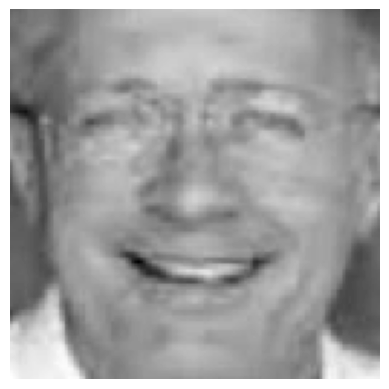

In [6]:
import matplotlib.pyplot as plt

image_index = 200

print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

image_to_predict = X[image_index].reshape(1, 128, 128, 1)

pred_gender = gender_model.predict(image_to_predict)
pred_gender_class = round(pred_gender[0][0])
pred_gender_label = gender_dict[pred_gender_class]

pred_age = age_model.predict(image_to_predict)
pred_age_value = round(pred_age[0][0])

print("Predicted Gender:", pred_gender_label, "Predicted Age:", pred_age_value)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()

In [7]:
gender_model.save('gender_model.h5')
age_model.save('age_model.h5')

### Extracting and Resizing Faces from Images using OpenCV

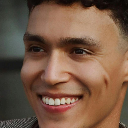

In [18]:
def extract_and_resize_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    image = cv2.imread(image_path)
    if image is None:
        print("Could not read the image.")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces found.")
        return None


    (x, y, w, h) = faces[0]
    face_image = image[y:y + h, x:x + w]

    face_image_resized = cv2.resize(face_image, (128, 128))

    return face_image_resized

output_face = extract_and_resize_face('/content/m_29_happy.jpg')
if output_face is not None:
    cv2_imshow(output_face)
    cv2.imwrite('output_face.jpg', output_face)

### Converting Keras Models to TensorFlow Lite Format

In [12]:
gender_model = tf.keras.models.load_model('gender_model.h5')
age_model = tf.keras.models.load_model('age_model.h5')

gender_converter = tf.lite.TFLiteConverter.from_keras_model(gender_model)
age_converter = tf.lite.TFLiteConverter.from_keras_model(age_model)

gender_converter.optimizations = [tf.lite.Optimize.DEFAULT]
age_converter.optimizations = [tf.lite.Optimize.DEFAULT]

gender_tflite_model = gender_converter.convert()
age_tflite_model = age_converter.convert()

with open('gender_model14.tflite', 'wb') as f:
    f.write(gender_tflite_model)

with open('age_model14.tflite', 'wb') as f:
    f.write(age_tflite_model)

### Gender and Age Prediction Using TensorFlow Lite Models

Predicted Gender: Male
Predicted Age: 32


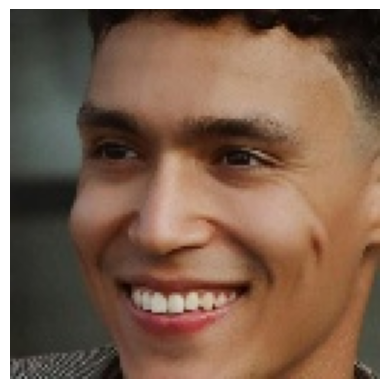

In [19]:

gender_interpreter = tf.lite.Interpreter(model_path='gender_model14.tflite')
age_interpreter = tf.lite.Interpreter(model_path='age_model14.tflite')

gender_interpreter.allocate_tensors()
age_interpreter.allocate_tensors()


gender_input_details = gender_interpreter.get_input_details()
gender_output_details = gender_interpreter.get_output_details()

age_input_details = age_interpreter.get_input_details()
age_output_details = age_interpreter.get_output_details()


image_path = '/content/output_face.jpg'


def preprocess_image(image_path):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = np.array(img, dtype=np.float32) / 255.0
    img = img.reshape(1, 128, 128, 1)
    return img

def predict(image_path):

    processed_image = preprocess_image(image_path)


    gender_interpreter.set_tensor(gender_input_details[0]['index'], processed_image)
    gender_interpreter.invoke()
    gender_prediction = gender_interpreter.get_tensor(gender_output_details[0]['index'])


    age_interpreter.set_tensor(age_input_details[0]['index'], processed_image)
    age_interpreter.invoke()
    age_prediction = age_interpreter.get_tensor(age_output_details[0]['index'])

    gender_dict = {0: 'Male', 1: 'Female'}
    pred_gender_class = round(gender_prediction[0][0])
    pred_gender_label = gender_dict[pred_gender_class]

    predicted_age = round(age_prediction[0][0])

    return pred_gender_label, predicted_age


predicted_gender, predicted_age = predict(image_path)

print(f"Predicted Gender: {predicted_gender}")
print(f"Predicted Age: {predicted_age}")

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()


### Gender and age Prediction from Face Images with Performance Metrics Calculation

In [28]:
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, mean_absolute_error
from tqdm import tqdm

interpreter_gender = tf.lite.Interpreter(model_path='/content/gender_model14.tflite')
interpreter_gender.allocate_tensors()

interpreter_age = tf.lite.Interpreter(model_path='/content/age_model14.tflite')
interpreter_age.allocate_tensors()

input_details_gender = interpreter_gender.get_input_details()
output_details_gender = interpreter_gender.get_output_details()

input_details_age = interpreter_age.get_input_details()
output_details_age = interpreter_age.get_output_details()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_and_resize_face(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read the image: {image_path}")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print(f"No faces found in: {image_path}")
        return None

    (x, y, w, h) = faces[0]
    face_image = image[y:y + h, x:x + w]
    face_image_resized = cv2.resize(face_image, (128, 128))

    return face_image_resized

def preprocess_image(face_image):
    img = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    img = np.array(img, dtype=np.float32) / 255.0
    img = img.reshape(1, 128, 128, 1)
    return img

def predict_gender(face_image):
    processed_image = preprocess_image(face_image)

    interpreter_gender.set_tensor(input_details_gender[0]['index'], processed_image)
    interpreter_gender.invoke()
    gender_prediction = interpreter_gender.get_tensor(output_details_gender[0]['index'])


    gender_dict = {0: 'Male', 1: 'Female'}
    pred_gender_class = 0 if gender_prediction[0][0] < 0.5 else 1
    pred_gender_label = gender_dict[pred_gender_class]

    return pred_gender_label, gender_prediction[0][0]

def predict_age(face_image):
    processed_image = preprocess_image(face_image)

    interpreter_age.set_tensor(input_details_age[0]['index'], processed_image)
    interpreter_age.invoke()
    age_prediction = interpreter_age.get_tensor(output_details_age[0]['index'])

    return age_prediction[0][0]

actual_gender_dict = {
    'm': 'Male',
    'w': 'Female'
}

dataset_folder = '/content/images'

results = []
actual_genders = []
predicted_genders = []
predicted_probabilities = []
predicted_ages = []
actual_ages = []

for filename in tqdm(os.listdir(dataset_folder)):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(dataset_folder, filename)
        face_image = extract_and_resize_face(image_path)

        if face_image is not None:

            predicted_gender, prob_gender = predict_gender(face_image)


            predicted_age = predict_age(face_image)


            actual_gender = actual_gender_dict[filename[0].lower()]

            actual_genders.append(actual_gender)
            predicted_genders.append(predicted_gender)
            predicted_probabilities.append(prob_gender)
            predicted_ages.append(predicted_age)


            actual_age = int(filename.split('_')[1])  # Modify this to extract actual age
            actual_ages.append(actual_age)

            results.append((filename, actual_gender, predicted_gender, prob_gender, actual_age, predicted_age))

results_df = pd.DataFrame(results, columns=['Filename', 'Actual Gender', 'Predicted Gender', 'Gender Probability', 'Actual Age', 'Predicted Age'])
print(results_df.to_string(index=False))

actual_genders_numeric = [0 if g == 'Male' else 1 for g in actual_genders]
predicted_genders_numeric = [0 if g == 'Male' else 1 for g in predicted_genders]

classification_rep = classification_report(actual_genders_numeric, predicted_genders_numeric, target_names=['Male', 'Female'])
print("Gender Classification Report:")
print(classification_rep)

mae_age = mean_absolute_error(actual_ages, predicted_ages)
print(f"Mean Absolute Error (MAE) for Age: {mae_age:.2f}")

def age_category(age):
    if age < 18:
        return 'Child'
    elif age <= 60:
        return 'Adult'
    else:
        return 'Senior'

actual_age_categories = [age_category(age) for age in actual_ages]
predicted_age_categories = [age_category(age) for age in predicted_ages]

age_classification_rep = classification_report(actual_age_categories, predicted_age_categories, target_names=['Child', 'Adult', 'Senior'])
print("Age Classification Report:")
print(age_classification_rep)



100%|██████████| 20/20 [01:28<00:00,  4.41s/it]

      Filename Actual Gender Predicted Gender  Gender Probability  Actual Age  Predicted Age
m_29_happy.jpg          Male           Female              0.9999          29        19.3239
  w_61_sad.jpg        Female           Female              0.8725          61        48.9144
  w_10_sad.jpg        Female           Female              1.0000          10         9.3082
  w_66_sad.jpg        Female             Male              0.0570          66        27.0058
  m_69_sad.jpg          Male             Male              0.3724          69        36.5722
  m_70_sad.jpg          Male             Male              0.0018          70        35.9244
  w_20_sad.jpg        Female           Female              1.0000          20        35.3760
w_53_happy.jpg        Female           Female              0.8578          53        29.8611
m_64_happy.jpg          Male             Male              0.0000          64        53.2985
  m_27_sad.jpg          Male             Male              0.0126     